In [5]:
# utf-8

%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import os
import numpy as np
from scipy.interpolate import griddata
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, FuncFormatter
from matplotlib.patches import Rectangle
import numpy as np
# Set the current directory and utilities path
current_dir = os.getcwd()#os.path.dirname(os.path.abspath(__file__))
utilities_dir = os.path.join(current_dir, '../../utilities')

# Change the working directory to the notebook's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

# Import necessary functions from utility modules
from analytical_solution_functions import sound_hard_circle_calc 
from analytical_solution_functions import mask_displacement
from bem_solution_functions import Circle_n
from bem_solution_functions import solveExteriorBoundary
from bem_solution_functions import solveExterior
from bem_solution_functions import generateInteriorPoints_excluding_circle
from plotting_functions import plot_bem_displacements_errors
from plotting_functions import plot_pinns_displacements_with_errorline
from analytical_solution_functions import sound_hard_circle_calc
from analytical_solution_functions import mask_displacement
from pinns_solution_functions import initialize_and_load_model
from pinns_solution_functions import predict_displacement_pinns
from pinns_solution_functions import process_displacement_pinns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Relative L2 error: 7.2672e-02


<string>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


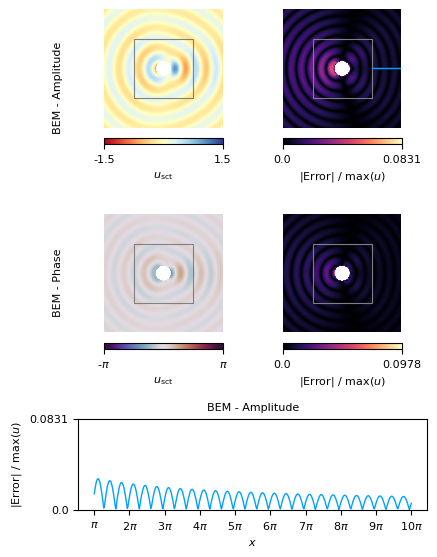

In [7]:
"""
Problem setup
"""

k = 3.0               # Wave number
n = 15                # Number of boundary elements (circular discretization)
n_dom = 2*40            # Number of domain sampling points (per axis)
r_exclude = np.pi / 4 # Radius of excluded circular region
l_se = np.pi          # Half-length of the computational domain
n_grid = 501          # Number of grid points along x and y

"""
Generate circular boundary mesh
"""

aVertex, aElement = Circle_n(n=n, radius=r_exclude)
num_elements = aElement.shape[0]
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])
theta = np.arctan2(aCenters[:, 1], aCenters[:, 0])  # Normal angle at each element center

"""
Apply Neumann boundary conditions
"""

alpha = np.full(num_elements, 0.0, dtype=complex)
beta  = np.full(num_elements, 1.0, dtype=complex)
f     = np.empty(num_elements, dtype=complex)
phi   = np.full(num_elements, 0.0, dtype=complex)
v     = np.full(num_elements, 0.0, dtype=complex)

# Compute incident field and its normal derivative
kx = k * aCenters[:, 0]
phi_inc = np.exp(1j * kx)
f = -1j * k * np.cos(theta) * phi_inc  # ∂φ_inc/∂n = i k cos(θ) φ_inc

"""
Generate interior points, excluding the circular obstacle
"""

points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-2*l_se, xmax=2*l_se,
    ymin=-2*l_se, ymax=2*l_se,
    r_exclude=r_exclude
)
interiorIncidentPhi = np.zeros(points_outside.shape[0], dtype=complex)

"""
Solve boundary integral equation (exterior problem)
"""

c, density = None, None
v, phi = solveExteriorBoundary(
    k, alpha, beta, f, phi, v,
    aVertex, aElement,
    c, density,
    'exterior'
)

"""
Evaluate scattered field at interior points
"""

interiorPhi = solveExterior(
    k, v, phi,
    interiorIncidentPhi,
    points_outside,
    aVertex, aElement,
    'exterior'
)

"""
Interpolate scattered field on a uniform grid
"""

Y, X = np.mgrid[-2*l_se:2*l_se:n_grid*1j, -2*l_se:2*l_se:n_grid*1j]
grid_z = griddata(points_outside, interiorPhi, (X, Y), method='cubic')
grid_z = np.ma.masked_where(np.sqrt(X**2 + Y**2) < r_exclude, grid_z)

# Extract real and imaginary parts
u_scn_amp = grid_z.real   # Scattered field amplitude
u_scn_phase = grid_z.imag # Scattered field phase

"""
Compute analytical solution for a sound-hard circular obstacle
"""

R_exact = np.sqrt(X**2 + Y**2)  # Radial distance from origin
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_exclude, X, Y, n_terms=None)

"""
Mask exact solution inside the circular obstacle
"""

u_inc_exact = mask_displacement(R_exact, r_exclude, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_exclude, l_se, u_scn_exact)
u_exact     = mask_displacement(R_exact, r_exclude, l_se, u_exact)

"""
Compute relative L2 error (real part of scattered field)
"""

# Create masked copies to zero-out interior region
R_grid = np.sqrt(X**2 + Y**2)
u_scn_exact_masked = np.copy(u_scn_exact)
u_scn_amp_masked   = np.copy(u_scn_amp)
u_scn_exact_masked[R_grid < r_exclude] = 0
u_scn_amp_masked[R_grid < r_exclude] = 0

relative_error = np.linalg.norm(u_scn_exact_masked.real - u_scn_amp_masked.real, 2) / \
                 np.linalg.norm(u_scn_exact_masked.real, 2)
print(f"Relative L2 error: {relative_error:.4e}")



# Línea radial desde el centro hacia +x, con y=0
x_line = np.linspace(np.pi, 10 * np.pi, 500)
y_line = np.zeros_like(x_line)
points_line = np.vstack((x_line, y_line)).T

# Evaluar campo BEM en puntos de la línea
interiorIncidentPhi_line = np.zeros(points_line.shape[0], dtype=complex)
phi_bem_line = solveExterior(
    k, v, phi,
    interiorIncidentPhi_line,
    points_line,
    aVertex, aElement,
    'exterior'
)

# Solución exacta
X_line, Y_line = x_line, y_line
u_inc_line, u_scn_exact_line, u_tot_exact_line = sound_hard_circle_calc(
    k, r_exclude,
    X_line, Y_line
)

# Error relativo
error_line = np.abs(np.real(u_scn_exact_line) - np.real(phi_bem_line))
rel_error_line = error_line / np.max(np.real(u_scn_exact_line))


plot_bem_displacements_errors(
    X, Y,
    u_scn_amp,
    np.real(u_inc_exact) + u_scn_amp,
    np.abs(np.real(u_scn_exact) - u_scn_amp),
    u_scn_phase,
    u_scn_phase + np.real(u_inc_exact),
    np.abs(np.imag(u_scn_exact) - u_scn_phase),
    x_line,
    rel_error_line
)

In [3]:
from analytical_solution_functions import sound_hard_circle_calc
from analytical_solution_functions import mask_displacement
from pinns_solution_functions import initialize_and_load_model
from pinns_solution_functions import predict_displacement_pinns
from pinns_solution_functions import process_displacement_pinns

# Parameters
r_i = np.pi / 4  # Inner radius
l_se = 2 * np.pi  # Outer semi-length
k = 3  # Wave number
n_grid = 2 * 501  # Number of grid points in x and y

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]

# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)

# Additional parameters
n_Omega_P = 10_000  # Number of points inside the annular region
n_Gamma_I = 100  # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 250  # Number of points on the outer boundary (r = r_e)
l_e = 2 * np.pi  # Length of the semi-edge of the square
k = 3.0  # Wave number
iter = 0  # Iteration counter
side_length = 2 * l_e  # Side length of the square

# Initialize and load the model
model_path = 'models/Scattering_2_75.pt'
model = initialize_and_load_model(model_path, 2, 75)

# Predict the displacement
u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns = predict_displacement_pinns(model, l_e, r_i, k, n_grid)

# Process the displacement
u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns, diff_uscn_amp_pinns, diff_u_scn_phase_pinns = process_displacement_pinns(
    model, l_e, r_i, k, n_grid, X, Y, R_exact, u_scn_exact
)

# Compute relative L2 error (real part of scattered field)
R_grid = np.sqrt(X**2 + Y**2)
u_scn_exact_masked = np.copy(u_scn_exact)
u_scn_amp_masked = np.copy(u_sc_amp_pinns)
u_scn_exact_masked[R_grid < r_i] = 0
u_scn_amp_masked[R_grid < r_i] = 0
relative_error = np.linalg.norm(u_scn_exact_masked.real - u_scn_amp_masked.real, 2) / np.linalg.norm(u_scn_exact_masked.real, 2)
print(f"Relative L2 error: {relative_error:.4e}")

Relative L2 error: 1.0574e+01


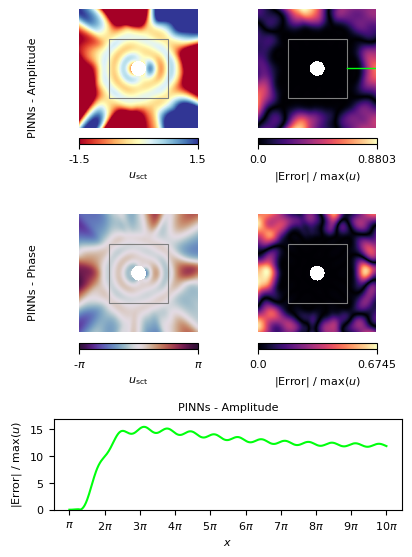

In [6]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Radial line from the center towards +x, with y=0
x_line = np.linspace(np.pi, 10 * np.pi, 500)
y_line = np.zeros_like(x_line)

# Convert X and Y data to PyTorch tensors and reshape
X_ten = torch.tensor(x_line).float().reshape(-1, 1).to(device)
Y_ten = torch.tensor(y_line).float().reshape(-1, 1).to(device)

# Initialize and load the model
model_path = 'models/Scattering_2_75.pt'
model = initialize_and_load_model(model_path, 2, 75)

# Concatenate X and Y tensors into a single tensor
domain_ten = torch.cat([X_ten, Y_ten], dim=1)
u_sc_pred = model(domain_ten)
u_sc_amp_pred = u_sc_pred[:, 0].detach().cpu().numpy().reshape(x_line.shape)
u_sc_phase_pred = u_sc_pred[:, 1].detach().cpu().numpy().reshape(x_line.shape)

# Note: u_scn_exact_line is not defined in the provided code, so relative error calculation is incomplete
# Assuming u_scn_exact_line is available, compute relative error
error_line = np.abs(np.real(u_scn_exact_line) - np.real(u_sc_amp_pred))
rel_error_line = error_line / np.max(np.real(u_scn_exact_line))

plot_pinns_displacements_with_errorline(
    X, Y,
    u_sc_amp_pinns,
    np.real(u_inc_exact) + u_sc_amp_pinns,
    np.abs(np.real(u_scn_exact) - u_sc_amp_pinns),
    u_sc_phase_pinns,
    u_sc_phase_pinns + np.real(u_inc_exact),
    np.abs(np.imag(u_scn_exact) - u_sc_phase_pinns),
    x_line,
    rel_error_line
)

In [8]:
# Change the working directory to the notebook's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

from svgutils.compose import *

# Load the SVGs
svg1 = SVG("figures/generalization_bem.svg")
svg2 = SVG("figures/generalization_pinns.svg")

# Create a figure using known dimensions
Figure(
    604,  # total width (still no math if you avoid this by guessing)
    401,  # height (or just use one of them)
    Panel(svg1),
    Panel(svg2).move(310, 0).scale(1.00)
).save("figures/generalization.svg")